# Vanilla DDPM Inpainting — Quantitative Evaluation

This notebook evaluates the vanilla DDPM inpainting pipeline (`vanilla_inpaint.py`) on **N images**
from the **MS COCO val2017** dataset, using **MNIST digit silhouettes** as masks.

The digit silhouette (~10% of the image) is erased and reconstructed.

**Pipeline:** For each image we use the COCO caption as the prompt and measure reconstruction quality
(SSIM, PSNR, LPIPS) on the **inpainted region only**.

**Output layout:**
```
eval_results/
  originals/           ← shared originals (written once)
  inpainted/           ← inpainting outputs
  masks/               ← masks (.pt)
  checkpoint.json
  metric_distributions.png
  top10_best.png
  top10_worst.png
```

In [1]:
import sys, os
import torch
import numpy as np
from tqdm.auto import tqdm
import random
from utils import (
    load_data, prepare_mnist_mask, prepare_coco_image, apply_mask_for_display,
    run_metrics,
    load_checkpoint, save_checkpoint,
    print_stats_table, plot_kde_single, show_top10,
)

# ---- Config ----
N_IMAGES       = 500
IMAGE_SIZE     = (512, 512)
SEED           = 42
STEPS          = 50
GUIDANCE_SCALE = 7.5
DATA_ROOT      = './data'
RESULTS_DIR    = 'eval_results'

os.makedirs(os.path.join(RESULTS_DIR, 'originals'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'inpainted'), exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'masks'),     exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f'Config: N_IMAGES={N_IMAGES}, SIZE={IMAGE_SIZE}, STEPS={STEPS}, GUIDANCE={GUIDANCE_SCALE}')
print(f'Output dirs: {RESULTS_DIR}/{{inpainted,masks}}')

/Users/roeikasuss/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config: N_IMAGES=1000, SIZE=(512, 512), STEPS=50, GUIDANCE=7.5
Output dirs: eval_results/{inpainted,masks}


In [2]:
selected_ids, id_to_filename, captions, mnist, mnist_indices = load_data(
    DATA_ROOT, seed=SEED, n_images=N_IMAGES
)

coco_img_dir = os.path.join(DATA_ROOT, 'coco', 'val2017')
coco_samples = [
    (id_to_filename[img_id], captions[img_id][0])
    for img_id in selected_ids
]

COCO images already present: data/coco/val2017
COCO annotations already present: data/coco/annotations/captions_val2017.json
Valid images (excluding people/animals): 1591
MNIST dataset size: 10000
Sampled 1000 image-mask pairs.


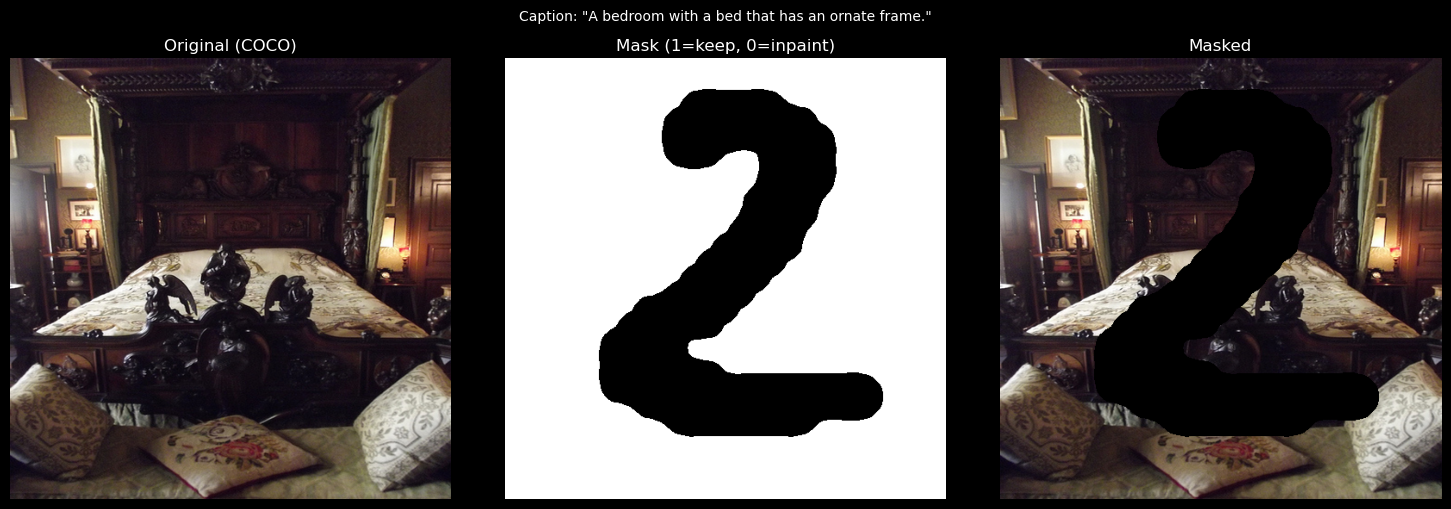

Inpainted region: 23.2% of image


In [3]:
import matplotlib.pyplot as plt

sample_filename, sample_caption = coco_samples[0]
sample_img   = prepare_coco_image(os.path.join(coco_img_dir, sample_filename))
sample_digit = mnist[mnist_indices[0]][0]

sample_mask   = prepare_mnist_mask(sample_digit)
sample_masked = apply_mask_for_display(sample_img, sample_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sample_img);                          axes[0].set_title('Original (COCO)')
axes[1].imshow(sample_mask.squeeze(), cmap='gray');  axes[1].set_title('Mask (1=keep, 0=inpaint)')
axes[2].imshow(sample_masked);                       axes[2].set_title('Masked')
for ax in axes:
    ax.axis('off')
plt.suptitle(f'Caption: "{sample_caption}"', fontsize=10, y=1.01)
plt.tight_layout()
plt.show()

frac = (sample_mask == 0).float().mean().item() * 100
print(f'Inpainted region: {frac:.1f}% of image')

In [4]:
# ---- Import model and inpainting function from vanilla_inpaint.py ----
sys.path.insert(0, os.path.abspath("."))
from vanilla_inpaint import ddpm_inpaint
from utils.cli import load_sd_pipeline


device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading model...")
pipe = load_sd_pipeline(device)
pipe.set_progress_bar_config(disable=True)  # suppress inner per-step bar
print("Model loaded.")

W0226 23:36:59.267000 54517 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/roeikasuss/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Using device: mps
Loading model...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 22.02it/s]


Model loaded.


In [5]:
INPAINTED_DIR = os.path.join(RESULTS_DIR, 'inpainted')
MASKS_DIR     = os.path.join(RESULTS_DIR, 'masks')
ORIGINALS_DIR = os.path.join(RESULTS_DIR, 'originals')

start_idx = load_checkpoint(RESULTS_DIR)

for i in tqdm(range(start_idx, N_IMAGES), initial=start_idx,
              total=N_IMAGES, desc='Inpainting'):
    filename, prompt = coco_samples[i]
    img_pil      = prepare_coco_image(os.path.join(coco_img_dir, filename))
    mask_tensor  = prepare_mnist_mask(mnist[mnist_indices[i]][0])

    inpainted_pil = ddpm_inpaint(
        pipe=pipe,
        image=img_pil,
        mask=mask_tensor,
        prompt=prompt,
        steps=STEPS,
        guidance_scale=GUIDANCE_SCALE,
        seed=SEED + i,
    )

    orig_path = os.path.join(ORIGINALS_DIR, f'{i:04d}.png')
    if not os.path.exists(orig_path):
        img_pil.save(orig_path)
        import json
        with open(os.path.join(ORIGINALS_DIR, f'{i:04d}.json'), 'w') as jf:
            json.dump({'caption': prompt}, jf)

    inpainted_pil.save(os.path.join(INPAINTED_DIR, f'{i:04d}.png'))
    torch.save(mask_tensor, os.path.join(MASKS_DIR, f'{i:04d}.pt'))
    save_checkpoint(RESULTS_DIR, i + 1, prompt)

print(f'Done. Inpainted {N_IMAGES} images.')

Resuming from image 100


Inpainting:  10%|█         | 102/1000 [00:52<6:33:45, 26.31s/it]


KeyboardInterrupt: 

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

results = run_metrics(
    inpainted_dir=os.path.join(RESULTS_DIR, 'inpainted'),
    masks_dir=os.path.join(RESULTS_DIR, 'masks'),
    originals_dir=os.path.join(RESULTS_DIR, 'originals'),
    n_images=N_IMAGES,
    device=device,
)

print(f'Metrics computed for {len(results)} images.')


In [ ]:
print_stats_table(results, label='Vanilla DDPM Inpainting (erase digit ~10%)')

plot_kde_single(
    results,
    out_path=os.path.join(RESULTS_DIR, 'metric_distributions.png'),
    title='Vanilla DDPM Inpainting — Metric Distributions',
)


In [ ]:
show_top10(
    results,
    sort_by='lpips', ascending=True,
    out_path=os.path.join(RESULTS_DIR, 'top10_best.png'),
)


In [ ]:
show_top10(
    results,
    sort_by='lpips', ascending=False,
    out_path=os.path.join(RESULTS_DIR, 'top10_worst.png'),
)
